## Image Classifier using NN

This project shows how to build an image classifier of your choice based on dataset of images you provide.

In [ ]:
#install a required library to use OSC protocol
!pip install https://github.com/attwad/python-osc/archive/master.zip
!pip install matplotlib
!conda install scikit-learn -y

This function, __load_dataset_from_folder__, will load image files from specific path. It will return an array of samples with their assigned label, and a list of labels.
<br>An example of dataset folder structure is the following:
<br>__Shoes__
<br>|-__children__
<br>|----|- imgA.jpg
<br>|----|- imgB.jpg
<br>|----| ....
<br>|----|- imgN.jpg
<br>|-__men__
<br>|----|- imgA.jpg
<br>|----|- imgB.jpg
<br>|----| ....
<br>|----|- imgN.jpg
<br>|-__women__
<br>|----|- imgA.jpg
<br>|----|- imgB.jpg
<br>|----| ....
<br>|----|- imgN.jpg

This will generate a dataset for shoes with labels: 
<br>children: 0
<br>men     :1
<br>women :2

In [1]:

from tensorflow.keras.datasets import mnist
from tensorflow.keras import utils
from PIL import Image
import os
import random

def load_dataset_from_folder(path,target_size=None,shuffle=True):
    dirs=os.listdir(path)
    labels=[]
    samples=[]
    index=0
    for i,l in enumerate(dirs):
        samples_dir=os.path.join(path,l)
        if not os.path.isdir(samples_dir):
            continue
        labels.append(l)
        samples_paths=os.listdir(samples_dir)
        for s in samples_paths:
            try:
                img=Image.open(os.path.join(samples_dir,s)).convert('L')
                if target_size!=None:
                    img=img.resize(target_size)
                #print("sample loaded",s)
                sample=[np.array(img),index]
                #if sample[0].shape[2]==3: #make sure its RGB with 3 channels
                samples.append(sample)
                img.close()
            except:
                continue
                
        index=index+1
        
    if shuffle:
        random.shuffle(samples)
    return np.array(samples),np.array(labels)

In [2]:
import numpy as np

#specify the size of images when loaded
TARGET_WIDTH=64
TARGET_HEIGHT=64
#specify the location of the dataset folder
Dataset="datasets/shoes"

samples,labels=load_dataset_from_folder(Dataset,target_size=(TARGET_WIDTH,TARGET_HEIGHT))

print("Loaded Labels")
for i,l in enumerate(labels):
    samples_count=len([s for s in samples if s[1]==i])
    print("{0}- [{1}] with total of {2} samples".format(i,l,samples_count))
    

Loaded Labels
0- [women shoes] with total of 145 samples
1- [men shoes] with total of 151 samples
2- [children shoes] with total of 150 samples


Show some random images from the loaded dataset

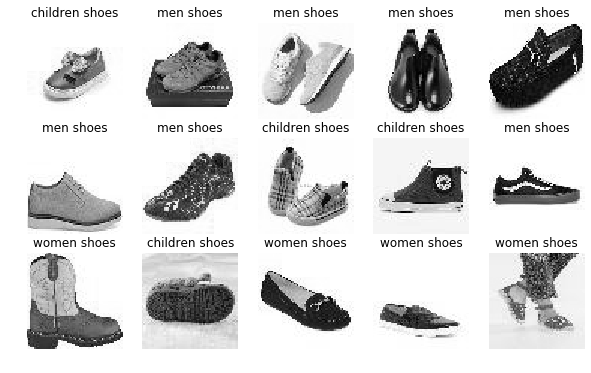

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import random

rows=3
cols=5
fig=plt.figure(figsize=(cols*2,rows*2))

for i in range(1,rows*cols+1):
    idx=random.randrange(0,len(samples))
    sample=samples[idx]
    img=sample[0]
    fig.add_subplot(rows,cols,i)
    plt.axis('off')
    plt.title(labels[sample[1]])
    plt.imshow(img,interpolation='nearest',cmap='gray')

plt.savefig("data.png", bbox_inches='tight')
plt.show()


## Preprocessing

Reshape the loaded samples to a 1D vector so it can be used in the neural network, and normalize image values.

Convert the labels from numbers to one-hot-encoding

In [10]:

from tensorflow.keras import utils

#Split to input X and labels Y
X=np.array([i[0] for i in samples])
Y=np.array([i[1] for i in samples])
 
#Flatten to 1D
X=X.reshape(X.shape[0],TARGET_WIDTH*TARGET_HEIGHT)

#normalize values
x_train=X/255.0

#prepare labels to one-hot-encoding
nb_classes=len(labels)
y_train = utils.to_categorical(Y, nb_classes)

Draw a random image after being pre-processed

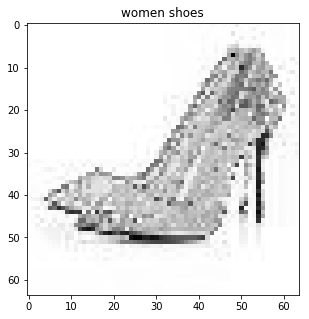

In [17]:

fig=plt.figure(figsize=(5,5))

index=random.randint(0,len(X_train)-1)
plt.imshow(X_train[index].reshape(TARGET_WIDTH,TARGET_HEIGHT),cmap='gray',interpolation='nearest')
plt.title(labels[np.argmax(y_train[index])])
plt.savefig("shoe.png", bbox_inches='tight')
plt.show()

Split dataset to train and validation

In [41]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(x_train,y_train,test_size=0.1)

print("Training using: {0} samples".format(len(X_train)))
print("Validating using: {0} samples".format(len(X_test)))

Training using: 401 samples
Validating using: 45 samples


## Model Creation

Create a model for training

In [20]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers

def create_model(input_len,nbclasses,firstLayer,nlayers,dropout=0.2):
    model=models.Sequential()
    model.add(layers.Dense(firstLayer,activation='relu',input_shape=(input_len,)))
    model.add(layers.Dropout(dropout))
    for l in nlayers:
        model.add(layers.Dense(l,activation='relu'))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(nbclasses,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [ ]:

from tensorflow.keras.callbacks import TensorBoard
from time import time

#prepare tensorboard
tensorboard = TensorBoard(log_dir="logs/Images_{}".format(time()))

TrainModel=True #Set to False to load pretrained model

X_train=np.array(X_train)
X_test=np.array(X_test)

Y_train=np.array(Y_train)
Y_test=np.array(Y_test)

model=create_model(X_train.shape[1],nb_classes,128,[64,32],dropout=0)
history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=200,batch_size=4, callbacks=[tensorboard])


## Test Samples

Load newly unseen samples to test them against the trained model. Check the accuracy of training.

In [26]:

#load test samples
sample_test,labels_test=load_dataset_from_folder("test/shoes/",target_size=(TARGET_WIDTH,TARGET_HEIGHT))
print("Loaded Test Samples")
for i,l in enumerate(labels_test):
    samples_count=len([s for s in sample_test if s[1]==i])
    print("{0}- [{1}] with total of {2} samples".format(i,l,samples_count))
    

Loaded Test Samples
0- [women shoes] with total of 36 samples
1- [men shoes] with total of 37 samples
2- [children shoes] with total of 36 samples


In [50]:
def preprocess_sample(sample):
    #normalize values
    sample=sample.reshape(TARGET_WIDTH*TARGET_HEIGHT)# convert to 1D array
    sample=sample/255.0 #scale to 0->1 range
    return sample

total=np.zeros(len(labels))
err=np.zeros(len(labels))
for s in sample_test:
    
    sample=preprocess_sample(s[0])#preprocess test sample
    res=model.predict(np.array([sample]))#predict its label
    
    total[s[1]]=total[s[1]]+1
    if labels_test[s[1]] !=labels[np.argmax(res)]:
        err[s[1]]=err[s[1]]+1
        flag="Error"
    else:
        flag="Correct"
    #print("{0} - Original: {1}  Predicted: {2}".format(flag,labels_test[s[1]],labels[np.argmax(res)]))
    
for i,e in enumerate(err):
    print("Accuracy for [{0}] is {1}%".format(labels_test[i], 100-int(100*e/float(total[i]))))

Accuracy for [women shoes] is 56%
Accuracy for [men shoes] is 33%
Accuracy for [children shoes] is 39%


## [Optional] OSC for realtime recognition


You can use this to communicate with external application (Processing for example) to predict images

In [ ]:
#setup OSC Protocol to communicate with Processing
import OSCHelper
server=OSCHelper.createServer(9000)
client=OSCHelper.createClient(4200)

In [240]:
import numpy as np
import io

def onOSC_Image(*args):
    width=args[1]
    height=args[2]
    jpgdata=args[3]
    file_jpgdata = io.BytesIO(jpgdata)
    img = Image.open(file_jpgdata).resize((TARGET_WIDTH,TARGET_HEIGHT)).convert("L")
    img=np.array(img).astype(float)
    img=(img-mean)/std
    x=np.reshape(img,(TARGET_WIDTH*TARGET_HEIGHT))
    res=model.predict(np.array([x]))
    label_idx=np.argmax(res)
    client.send_message("/output/label",[int(label_idx),str(labels[label_idx])])
    #plt.imshow(img,cmap='gray')
    #plt.title("Prediction:{0}".format(labels[label_idx]))
    #plt.show()

server.addMsgHandler( "/inputs/image", onOSC_Image )

OSCHelper.start_server(server)


In [256]:
server.close()
